In [29]:
import pandas as pd
import numpy as np

In [30]:
train_df = pd.read_csv('datasets/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
train_df = pd.get_dummies(train_df, columns=['Sex']).drop(columns='Sex_female')
train_df = train_df.fillna({'Age': train_df['Age'].median()})
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [34]:
from data import normalize_columns
normalize_columns(train_df, columns=['Age', 'Fare'])
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,0.271174,0.014151,1
1,1,1,0.472229,0.139136,0
2,1,3,0.321438,0.015469,0
3,1,1,0.434531,0.103644,0
4,0,3,0.434531,0.015713,1


In [35]:
X = train_df.drop(columns='Survived')
y = train_df['Survived']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Самописный градиентный спуск + логистическая регрессия

In [51]:
from linear import StandardGradientDescent
from quality_functional import LogisticLoss
from quality_functional import Accuracy

accs = []

for S in range(10, 1000, 10):
    gd = StandardGradientDescent(alpha=0.005, S=S, loss=LogisticLoss)
    gd.fit(X_train, y_train)
    y_pred = gd.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accs.append(Accuracy.get_accuracy(y_pred, y_test))

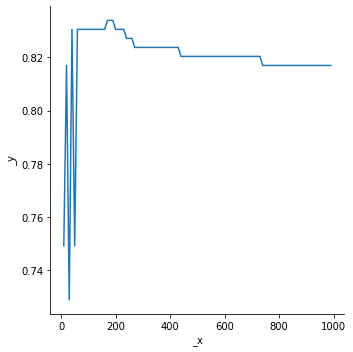

In [52]:
import seaborn as sns
sns.relplot(x=list(range(10, 1000, 10)), y=accs, kind='line')

Оптимальное S = ~200

In [54]:
gd = StandardGradientDescent(alpha=0.001, S=180, loss=LogisticLoss)
gd.fit(X_train, y_train)
y_pred = gd.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
Accuracy.get_accuracy(y_pred, y_test)

0.8

In [72]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [74]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [56]:
predicts_df = pd.DataFrame(test_df['PassengerId'])

In [75]:
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
test_df = pd.get_dummies(test_df, columns=['Sex']).drop(columns='Sex_female')
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Age'].mean()})
normalize_columns(test_df, columns=['Age', 'Fare'])
test_df.head()

,Pclass,Age,Fare,Sex_male
0,3,0.452723,0.015282,1
1,3,0.617566,0.013663,0
2,2,0.815377,0.018909,1
3,3,0.353818,0.016908,1
4,3,0.287881,0.023984,0


In [76]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)

In [77]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат ~0.73, но включив фичу Fare результат возрос до 0.767

# Логистическая регрессия sklearn

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
lr = LogisticRegression(penalty='none')

In [80]:
lr.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [81]:
Accuracy.get_accuracy(lr.predict(X_test), y_test)

0.8067796610169492

In [82]:
test_df['Fare'].unique()

array([0.01528158, 0.01366309, 0.01890874, 0.01690807, 0.0239836 ,
       0.018006  , 0.01489121, 0.05660423, 0.01411046, 0.04713766,
       0.01541158, 0.05074862, 0.1605739 , 0.11940565, 0.0541074 ,
       0.02410559, 0.01410226, 0.01546857, 0.11594108, 0.00618899,
       0.06184168, 0.11980422, 0.51212189, 0.02830212, 0.12097534,
       0.05953204, 0.04231498, 0.06148391, 0.04015973, 0.04577135,
       0.11272049, 0.01571255, 0.01854277, 0.11027246, 0.02618765,
       0.05182215, 0.01532218, 0.02537431, 0.10257897, 0.05797054,
       0.01512699, 0.14891148, 0.03103473, 0.1171122 , 0.02934305,
       0.04489301, 0.51334181, 0.03040857, 0.05684821, 0.01493181,
       0.03142511, 0.02635025, 0.0150782 , 0.04098927, 0.01537917,
       0.08275929, 0.05570149, 0.41282051, 0.05016306, 0.02975782,
       0.43288417, 0.02090121, 0.02821272, 0.02713099, 0.01517579,
       0.10149724, 0.01521639, 0.15390495, 0.01533038, 0.10821499,
       0.01662349, 0.04396587, 0.01526518, 0.01700567, 0.02936

In [67]:
predicts_df['Survived'] = lr.predict(test_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат без регуляризации ~0.74

Попробую улучшить результат, варьируя различные параметры этой модели

In [ ]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
lr.fit(X_train, y_train)
Accuracy.get_accuracy(lr.predict(X_test), y_test)

In [ ]:
predicts_df['Survived'] = lr.predict(test_df)
predicts_df.to_csv('predicts.csv', index=False)

### L1-регуляризация здесь показала лучший результат, чем L2 (~0.76 против ~0.75)